In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install mxnet
!pip install d2l


In [5]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [6]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

In [7]:
def read_csv_labels(fname):
    """Read fname to return a name to label dictionary."""
    with open(fname, 'r') as f:
        # Skip the file header line (column name)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    # The number of examples of the class with the least examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        # Copy to train_valid_test/train_valid with a subfolder per class
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            # Copy to train_valid_test/valid
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # Copy to train_valid_test/train
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

# training examples: 1000
# classes: 10


In [8]:
batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

transform_train = torchvision.transforms.Compose([
    # Magnify the image to a square of 40 pixels in both height and width
    torchvision.transforms.Resize(40),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then shrink it to a square of 32 pixels in both height and
    # width
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # Normalize each channel of the image
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)


In [9]:
def get_net():
    num_classes = 10
    # PyTorch doesn't have the notion of hybrid model
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")



In [10]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    if valid_iter is not None:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}, '
              f'valid acc {valid_acc:.3f}')
    else:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

# Primeiro teste

loss 1.057, train acc 0.630, valid acc 0.438
286.1 examples/sec on [device(type='cuda', index=0)]


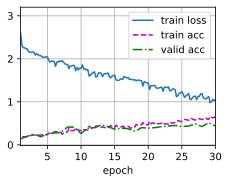

In [11]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 30, 0.001, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# Segundo teste

loss 0.721, train acc 0.767, valid acc 0.525
285.3 examples/sec on [device(type='cuda', index=0)]


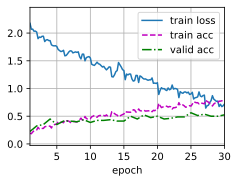

In [12]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 30, 0.0001, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# Terceiro teste

loss 0.546, train acc 0.813, valid acc 0.475
286.9 examples/sec on [device(type='cuda', index=0)]


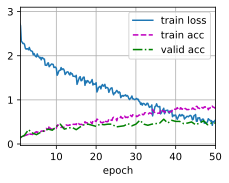

In [13]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 50, 0.001, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# Quarto teste

loss 1.464, train acc 0.477, valid acc 0.537
286.1 examples/sec on [device(type='cuda', index=0)]


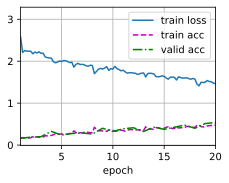

In [21]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 0.001, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [22]:
torch.save(net.state_dict(), "cifar10.pth")

In [24]:
!pip install flask ngrok torch torchvision

In [25]:
!pip install flask-ngrok

In [26]:
from flask import Flask, request, jsonify
from PIL import Image
from flask_ngrok import run_with_ngrok
import d2l.torch as d2l

In [39]:
from flask import Flask, request, jsonify
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import d2l.torch as d2l
from google.colab.output import eval_js
from IPython.display import display, Javascript

app = Flask(__name__)

# Categorias do CIFAR-10
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Carregar o modelo
def load_model(model_path):
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    net.eval()
    return net

model_path = './cifar10.pth'
model = load_model(model_path)

# Transformações para a imagem
transform = transforms.Compose([
    transforms.Resize(40),
    transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

@app.route('/predict', methods=['POST'])
def predict():
    files = request.files.getlist('file')
    if not files:
        return jsonify({'error': 'No files provided'}), 400

    predictions = []
    for file in files:
        img = Image.open(io.BytesIO(file.read()))
        img = transform(img).unsqueeze(0)
        with torch.no_grad():
            output = model(img)
            _, predicted = torch.max(output, 1)
            category_idx = predicted.item()
            category = CIFAR10_CLASSES[category_idx]
            predictions.append({'category': category, 'category_index': category_idx})

    return jsonify({'predictions': predictions})

# Função para iniciar o servidor Flask
def start_server():
    app.run(port=3000)

# Iniciar o servidor Flask em uma thread separada
from threading import Thread
Thread(target=start_server).start()
print("Servidor rodando em: ")
display(Javascript('window.open("http://localhost:3000")'))


<IPython.core.display.Javascript object>

Servidor rodando em: 
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:3000
INFO:werkzeug:Press CTRL+C to quit


In [41]:
import requests

url = 'http://127.0.0.1:3000/predict'
files = [
    ('file', open('/content/cavalo.jpg', 'rb')),
    ('file', open('/content/cachorro.jpg', 'rb')),
    ('file', open('/content/sapo.jpg', 'rb'))
]
response = requests.post(url, files=files)
print(response.json())



INFO:werkzeug:127.0.0.1 - - [01/Jun/2024 19:00:51] "POST /predict HTTP/1.1" 200 -


{'predictions': [{'category': 'frog', 'category_index': 6}, {'category': 'dog', 'category_index': 5}, {'category': 'frog', 'category_index': 6}]}
